In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.efm as exp_efm

# truncation

In [17]:
dim = 1
n = 500

X_ls = []
pval_ls_imq = []
pval_ls_tilted = []
pval_ls_boot = []
for trunc in [False, True]:
    np.random.seed(54321)
    
    ###
    X = jnp.array(np.random.normal(np.zeros((dim,)), size=(n, dim)))
    if trunc:
        X = jnp.round(X, 1)
    
    X_ls.append(X)
    
    score_fn = lambda x: - x
    ###
    
    # IMQ
    kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
    
    ksd = metrics.KSD(kernel, score_fn=score_fn)
    wild_boot = boot.WildBootstrap(ksd)
    pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
    
    pval_ls_imq.append(float(pval))

In [18]:
pval_ls_imq

[0.2407592386007309, 0.21178820729255676]

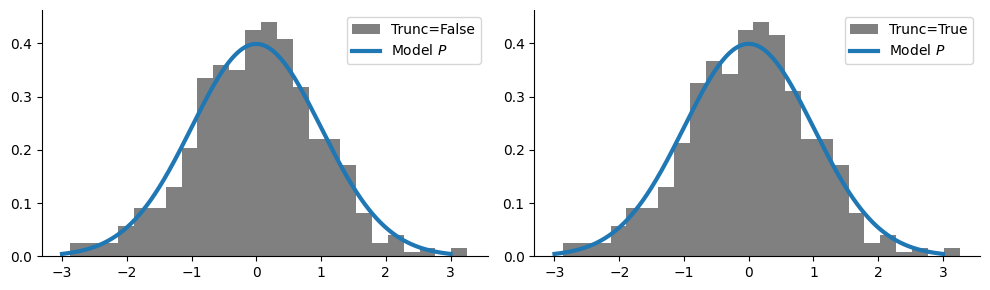

In [10]:
_, axes = plt.subplots(ncols=2, figsize=(10, 3))

xvals = jnp.linspace(-3., 3., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# pvals_df = pd.DataFrame({"IMQ": pval_ls_imq, "Tilted": pval_ls_tilted}, index=["Without", "With"])

for i, trunc in enumerate([False, True]):
    ax = axes[i]
    ax.hist(X_ls[i].reshape(-1), bins=25, color="grey", density=True, label=f"Trunc={trunc}")
    # ax.get_yaxis().set_visible(False)

    ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    
    ax.legend()

plt.tight_layout()
# plt.savefig("../figs/robust/ucl_fig.pdf")

# OL

In [143]:
dim = 1
n = 500
nreps = 100
ol_mean = 10.
eps_ls = [0., 0.01]

Xs_ls = []
pval_ls_imq = []
pval_ls_tilted = []
pval_ls_boot = []
for eps in eps_ls:
    np.random.seed(54321)
    
    ###
    mean1 = np.zeros((dim,)) # data
    mean2 = np.zeros((dim,)) # model
    
    Xs = jnp.array(np.random.normal(mean1, size=(nreps, n, dim)))
    n_outlier = int(n * eps)
    Xs = jax.vmap(lambda x: exp_efm.sample_outlier_contam(x, eps, ol_mean, 0.1))(Xs)

    Xs_ls.append(Xs)
    
    score_fn = lambda x: - (x - mean2)
    ###
    
    # # IMQ
    # kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
    
    # ksd = metrics.KSD(kernel, score_fn=score_fn)
    # wild_boot = boot.WildBootstrap(ksd)
    # pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
    
    # pval_ls_imq.append(float(pval))

    # R-KSD boot
    score = score_fn(Xs)
    hvp = - score

    hvp_denom_sup = 1.
    theta = 0.1
    res = exp_utils.run_tests(
        samples=Xs, scores=score, hvps=hvp, hvp_denom_sup=hvp_denom_sup, 
        theta="ol", eps0=0.1, bw="med", alpha=0.05, verbose=True,
    )
    pval_ls_imq.append(res["standard"]["pval"])
    pval_ls_tilted.append(res["tilted"]["pval"])
    pval_ls_boot.append(res["tilted_r_boot"]["pval"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


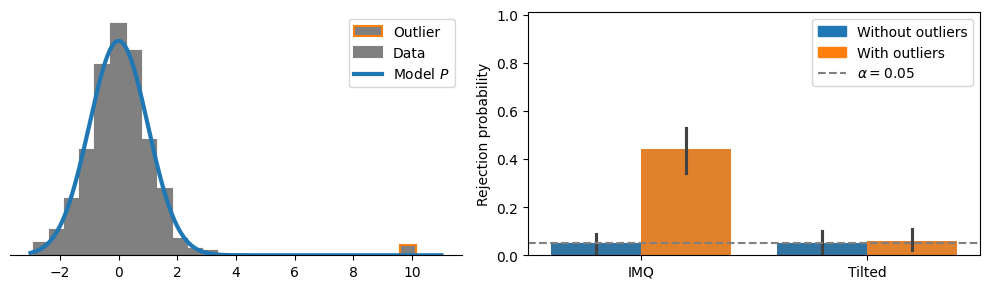

In [141]:
from pylab import setp
import matplotlib


# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    c1, c2 = "C0", "C1"
    setp(bp['boxes'][0], color=c1, linewidth=2)
    setp(bp['caps'][0], color=c1, linewidth=2)
    setp(bp['caps'][1], color=c1, linewidth=2)
    setp(bp['whiskers'][0], color=c1, linewidth=2)
    setp(bp['whiskers'][1], color=c1, linewidth=2)
    # setp(bp['fliers'][0], color=c1)
    # setp(bp['fliers'][1], color=c1)
    setp(bp['medians'][0], color=c1, linewidth=2)

    setp(bp['boxes'][1], color=c2, linewidth=2)
    setp(bp['caps'][2], color=c2, linewidth=2)
    setp(bp['caps'][3], color=c2, linewidth=2)
    setp(bp['whiskers'][2], color=c2, linewidth=2)
    setp(bp['whiskers'][3], color=c2, linewidth=2)
    setp(bp['medians'][1], color=c2, linewidth=2)

_, axes = plt.subplots(ncols=2, figsize=(10, 3))

bins = np.histogram(np.hstack(
    (X_ls[0].reshape(-1), X_ls[1].reshape(-1))
), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# hist plots
ax = axes[0]
ax.hist(X_ls[1].reshape(-1), bins, color="grey", density=True, edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(X_ls[0].reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
# ylim = ax.get_ylim()
# ax.hist(X_ls[1][X_ls[1] > 6.].reshape(-1), bins, color="white", density=True, label="Outlier", edgecolor='black', linewidth=1.2)
# ax.set_ylim(ylim)
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

# # boxplots
# ax = axes[1]
# b1 = ax.boxplot(pval_ls_imq, positions=[1, 1.3], widths=0.2, showfliers=False)
# setBoxColors(b1)

# b2 = ax.boxplot(pval_ls_tilted, positions=[2, 2.3], widths=0.2, showfliers=False)
# setBoxColors(b2)

# h3 = ax.axhline(0.05, color="grey", linestyle="--")

# ax.set_xlim(0.8, 3.)
# ax.set_ylim(0, 1.01)

# ax.set_xticks([1.15, 2.15])
# ax.set_xticklabels(["IMQ", "Tilted"])
# ax.set_ylabel("p-values")

# boxplots
ax = axes[1]
df = pd.DataFrame({
    "rej": (np.concatenate(pval_ls_imq + pval_ls_tilted, 0) < 0.05).tolist(),
    "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2,
    "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
})
b = sns.barplot(data=df, x="method", y="rej", hue="Outlier")
h3 = ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylim(0, 1.01)
ax.set_xlabel("")
ax.set_ylabel("Rejection probability")
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in b.get_xticklabels())]
ax.legend(handles=patches+[h3], labels=["Without outliers", "With outliers", r"$\alpha=0.05$"])

plt.tight_layout()
# plt.savefig("../figs/robust/ucl_ol_thumbnail.pdf")

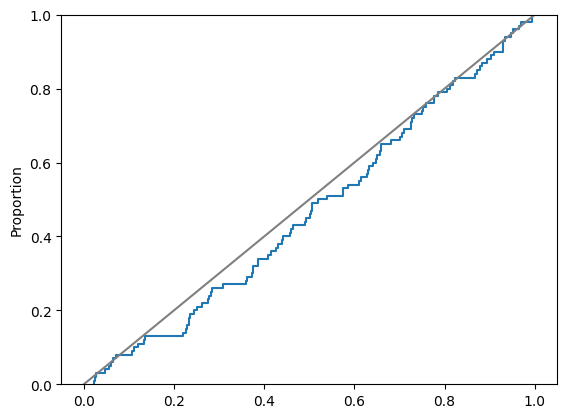

In [144]:
sns.ecdfplot(x=np.array(pval_ls_tilted[0]))
plt.plot([0., 1], [0., 1], color="grey")

# Blind to missing modes

In [62]:
np.random.seed(2024)

In [63]:
def create_mixture_gaussian_kdim_logprobb(dim, k, delta, ratio=0.5, shift=0.):
    """
    Evaluate the log density at the points (rows) in X 
    of the standard isotropic Gaussian.
    Note that the density is NOT normalized. 
    
    X: n x d nd-array
    return a length-n array
    """
    a = [1. if x < k else 0. for x in range(dim)]
    a = np.array(a)
    multiplier = delta / np.sqrt(float(k))
    mean1 = np.zeros(dim) + shift
    mean2 = multiplier * a + shift

    variance = 1

    if ratio == 0.:
        def log_prob_fn(X):
          unden = -0.5 * jnp.sum((X-mean1)**2, axis=-1) / variance
          return jnp.squeeze(unden)
            
    elif ratio == 1.:
        def log_prob_fn(X):
          unden = -0.5 * jnp.sum((X-mean2)**2, axis=-1) / variance
          return jnp.squeeze(unden)

    else:
        log_ratio1 = np.log(ratio)
        log_ratio2 = np.log(1-ratio)
        
        def log_prob_fn(X):
          exp1 = -0.5 * jnp.sum((X-mean1)**2, axis=-1) / variance + log_ratio1
          exp2 = -0.5 * jnp.sum((X-mean2)**2, axis=-1) / variance + log_ratio2
          unden = jnp.logaddexp(exp1, exp2) # n
          return jnp.squeeze(unden)

    return log_prob_fn

def draw_mixture(n, d, ratio, delta):
    n1 = int(n * ratio)
    n2 = n - n1
    X1 = np.reshape(
        np.random.normal(size=(n1,)),
        (-1, d),
    )
    X2 = np.reshape(
        np.random.normal(size=(n2,), loc=delta),
        (-1, d),
    )
    X = jnp.concatenate([X1, X2], 0)
    return X

In [79]:
n = 1000
dim = 1
nrep = 100

pi_ls = jnp.linspace(0., 1., 11)
delta = 6.

kernel = kernels.IMQ(sigma_sq=2*1.**2)
ksd = metrics.KSD(kernel)

log_prob = create_mixture_gaussian_kdim_logprobb(1, 1, delta=delta, ratio=.5)
score_fn = jax.vmap(jax.grad(log_prob))

ksd_ls = {}
X_ls = {}
score_ls = {}
for pi in pi_ls:
    pi = float(pi)
    ksd_ls[pi] = []
    X_ls[pi] = []
    score_ls[pi] = []

    for _ in trange(nrep):
        X = draw_mixture(n, dim, pi, delta)
        X_ls[pi].append(X)
        
        score = score_fn(X)
        score_ls[pi].append(score)
        
        ksd_ls[pi].append(ksd(X, X, score=score, vstat=False))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [132]:
import matplotlib as mpl

mpl.rcParams["mathtext.fontset"] = "cm"

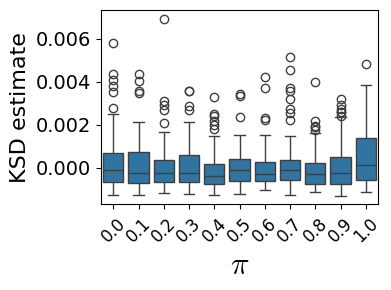

In [114]:
df = pd.DataFrame({
    "pi": [round(float(i), 1) for pi in pi_ls for i in [pi]*nrep],
    "ksd": [float(i) for pi in pi_ls for i in ksd_ls[float(pi)]],
})

_, ax = plt.subplots(ncols=1, figsize=(4, 3))
sns.boxplot(ax=ax, data=df, x="pi", y="ksd")
_ = plt.xticks(rotation=45, fontsize=12)
_ = plt.yticks(fontsize=14)
ax.set_ylabel("KSD estimate", fontsize=16)
ax.set_xlabel("$\pi$", fontsize=22, math_fontfamily="cm")
plt.tight_layout()

# plt.savefig("../figs/robust/mixture_ksd.pdf")

In [133]:
pi_ls = [0., 0.2, 0.5, 0.7, 1.]
X = jnp.linspace(-5., 10., 501)
score_ls = []
for pi in pi_ls:
    log_prob = create_mixture_gaussian_kdim_logprobb(1, 1, delta=delta, ratio=.5)
    score_fn = jax.vmap(jax.grad(log_prob))
    score_ls.append(score_fn(X))

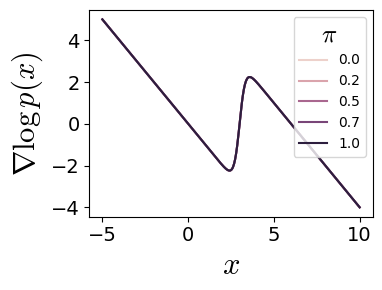

In [149]:
df = pd.DataFrame({
    "x": X.tolist() * len(pi_ls),
    "score": [float(ss) for scores in score_ls for ss in scores],
    "pi": [round(float(i), 1) for pi in pi_ls for i in [pi]*len(X)],
})

_, ax = plt.subplots(ncols=1, figsize=(4, 3))
sns.lineplot(ax=ax, data=df, x="x", y="score", hue="pi")
ax.legend(title=r"$\pi$", title_fontsize=18)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)
ax.set_xlabel("$x$", fontsize=22)
ax.set_ylabel(r"$\nabla \log p(x)$", fontsize=22)
plt.tight_layout()

# plt.savefig("../figs/robust/mixture_score.pdf")

# Scalability to high dim

In [183]:
np.random.seed(2024)

In [184]:
n = 50
dim_ls = [1, 5, 10, 25, 50, 100]
nrep = 100

kernel = kernels.IMQ(sigma_sq=2*1.**2)
ksd = metrics.KSD(kernel)

ksd_ls = {}
X_ls = {}
score_ls = {}
rej_ls = {}
for dim in dim_ls:
    ksd_ls[dim] = []
    X_ls[dim] = []
    score_ls[dim] = []
    rej_ls[dim] = []
    
    mean = np.eye(dim)[0]
    for _ in trange(nrep):
        X = np.random.multivariate_normal(mean, np.eye(dim), size=(n,))
        X_ls[dim].append(X)
        
        score = -X
        score_ls[dim].append(score)
        
        ksd_ls[dim].append(ksd(X, X, score=score, vstat=False))

        wild_boot = boot.WildBootstrap(ksd)
        pval = wild_boot.pval(X, X, score=score)
        rej_ls[dim].append(int(pval <= 0.05))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

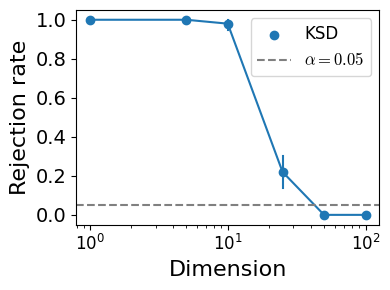

In [186]:
df = pd.DataFrame({
    "dim": [d for d in dim_ls for _ in range(nrep)],
    "rej": [r for d in dim_ls for r in rej_ls[d]],
    "name": ["ksd" for d in dim_ls for _ in range(nrep)]
})

_, ax = plt.subplots(ncols=1, figsize=(4, 3))

sns.lineplot(ax=ax, data=df, x="dim", y="rej", err_style="bars")
ax.scatter(dim_ls, [np.mean(rej_ls[d]) for d in dim_ls], label="KSD")
ax.set_xscale("log")
ax.axhline(0.05, label=r"$\alpha = 0.05$", linestyle="--", color="grey")
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=14)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.set_xlabel("Dimension", fontsize=16)
ax.legend(fontsize=12)
plt.tight_layout()

# plt.savefig("../figs/robust/dim.pdf")